In [139]:
from __future__ import division
import pandas as pd
import numpy as np
from matplotlib import pyplot
%matplotlib inline

# Load Dataset

In [2]:
data = (pd.read_csv('posting_clicks.csv', ',')
        .rename(columns={'USER_ID': 'user', 'ITEM_ID': 'item', 'CREATED_AT': 'ts', 'ITEM_TYPE': 'i_type'}))

# Basic dataset statistics

In [3]:
data.user.unique().shape[0], data.item.unique().shape[0]

(273573, 321791)

In [4]:
data.ts.min(), data.ts.max()

('2014-08-11 00:00:00.000000', '2014-08-24 23:59:59.000000')

In [5]:
data.dtypes

user       int64
item       int64
ts        object
i_type     int64
dtype: object

Item types distibution over dataset

In [6]:
data.i_type.value_counts().order()

1     901770
2    1675731
dtype: int64

Unique items per item type

In [280]:
data.groupby('i_type').apply(lambda df: df.item.unique().shape[0])

i_type
1     17711
2    304080
dtype: int64

Percentage of users with more than one item type clicks

In [9]:
(data.groupby('user').apply(lambda df: df.i_type.unique().shape[0])>1).mean()

0.085249640863681725

Users with more than one item type clicks

In [10]:
ser = data.groupby('user').apply(lambda df: df.i_type.unique().shape[0]>1)
two_itype_users = ser[ser].index

In [11]:
two_itype_users.shape[0], two_itype_users[:10]

(23322, Int64Index([23, 31, 43, 48, 51, 53, 58, 62, 67, 68], dtype='int64'))

Clicks bar plot for the most active users

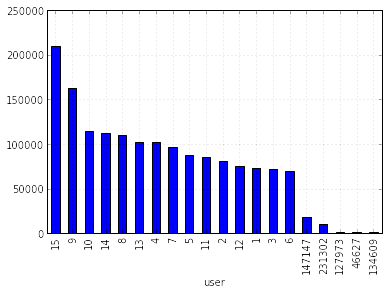

In [14]:
data.groupby('user').size().order(ascending=False).head(20).plot(kind='bar')

Typical users with clicks of two item types. Quite often user series starts or ends with item type of another type.

In [282]:
data[data.user == 23].sort(['user','ts']).head(10)

,user,item,ts,i_type
485275,23,298343,2014-08-11 20:17:04.000000,2
485669,23,267766,2014-08-11 20:20:16.000000,2
2119713,23,299734,2014-08-12 12:20:12.000000,2
2119798,23,299734,2014-08-12 12:20:39.000000,2
1063729,23,317618,2014-08-20 09:16:25.000000,1


Top active users number of item types

In [18]:
act_users_top = data.groupby('user').size().order(ascending=False).head(20).index

In [19]:
data[data.user.isin(act_users_top)].groupby('user').apply(lambda df: df.i_type.unique().shape[0])

user
1         1
2         1
3         1
4         1
5         1
6         1
7         1
8         1
9         1
10        1
11        1
12        1
13        1
14        1
15        1
46627     1
127973    1
134609    1
147147    1
231302    1
dtype: int64

# Split Dataset

Prepare subset of data that contains users with enouch clicks and doesn't contain the top active users. The second group of users doesn't look like real people.

In [46]:
ts_n = 3
ser = data.groupby('user').size()
users_clicks_gtn = ser[ser>ts_n].index
data2 = data[data.user.isin(users_clicks_gtn)&(data.user.isin(act_users_top) == False)].sort(['user', 'ts'])

In [47]:
data2.shape[0], data2.user.unique().shape[0]

(685394, 68580)

In [218]:
ser = data2.groupby('user').apply(lambda df: df.i_type.unique().shape[0])
users_one_type = ser[ser==1].index

Prepare subset that contains only users with more than one item type clicks. As for users with only one item type the best approach would be using the same item type for all types of predictions.

In [219]:
data3 = data2[data2.user.isin(users_one_type) == False]
data3.shape[0], data3.user.unique().shape[0]

(153128, 14102)

Split resulting dataset into train and test

In [220]:
test_df = data3.groupby('user').apply(lambda df: df.iloc[-ts_n:]).reset_index(drop=True)
test = test_df.set_index(['user', 'ts'])['i_type']

In [221]:
test.head()

user  ts                        
23    2014-08-12 12:20:12.000000    2
      2014-08-12 12:20:39.000000    2
      2014-08-20 09:16:25.000000    1
43    2014-08-20 13:56:07.000000    1
      2014-08-20 13:57:13.000000    1
Name: i_type, dtype: int64

In [222]:
train = data3.groupby('user').apply(lambda df: df.iloc[:-ts_n]).reset_index(drop=True)

# Pop Predictor

The simplest approach - use the most popular user item type for all predictions.

In [223]:
top_user_itype = (train.groupby('user').apply(lambda df: df.i_type.value_counts().index[0])
                  .reset_index().rename(columns={0: 'i_type'}))
top_user_itype.head()

,user,i_type
0,23,2
1,43,2
2,48,1
3,51,1
4,53,2


In [224]:
#top_user_itype
base_pred_df = test.copy().reset_index().drop('i_type', axis=1).merge(top_user_itype, on='user')
base_pred = base_pred_df.set_index(['user', 'ts'])['i_type']
base_pred.head()

user  ts                        
23    2014-08-12 12:20:12.000000    2
      2014-08-12 12:20:39.000000    2
      2014-08-20 09:16:25.000000    2
43    2014-08-20 13:56:07.000000    2
      2014-08-20 13:57:13.000000    2
Name: i_type, dtype: int64

#### validation
Total accuracy of the model

In [225]:
(test == base_pred).mean()

0.60353141398383203

# Assoc Rules Predictor

Using modified association rules for predicting user item type preferences

In [226]:
item_type_map = data3[['item', 'i_type']].drop_duplicates().set_index('item')['i_type'].to_dict()

Function for getting all user item pairs: item1 -> item2.type
There is no difference in number of days of events between two items of the pair

In [227]:
def get_item_sets(df, item_type_map):
    res = []
    for i in range(len(df)):
        for j in range(i+1, len(df)):
            res.append( (df.item.iloc[i], item_type_map[df.item.iloc[j]]) )
    return res

Get all users' item pairs

In [228]:
user_itemsets_df = data3.groupby('user').apply(lambda df: get_item_sets(df, item_type_map))
user_itemsets_df.head()

user
23    [(298343, 2), (298343, 2), (298343, 2), (29834...
43    [(300836, 1), (300836, 1), (300836, 1), (30815...
48    [(309043, 1), (309043, 1), (309043, 1), (30904...
51    [(305674, 1), (305674, 1), (305674, 1), (30567...
53    [(280270, 2), (280270, 2), (280270, 2), (28027...
dtype: object

In [229]:
user_itemsets_df.shape, np.vstack(user_itemsets_df.values).shape

((14102,), (2079382, 2))

Compute assoc rules support

In [230]:
assoc_rule_sup = (pd.DataFrame(np.vstack(user_itemsets_df.values), columns=['item', 'next_i_type'])
 .groupby(['item', 'next_i_type']).size())

In [231]:
assoc_rule_sup.name = 'sup'
item_sup = assoc_rule_sup.reset_index().groupby('item').sup.sum()
item_sup.head()

item
54     4
59     2
68    30
93    10
99     1
Name: sup, dtype: int64

Compute assoc rules confidence

In [232]:
assoc_rules_conf = assoc_rule_sup.reset_index().merge(item_sup.reset_index(), on='item')
assoc_rules_conf['conf'] = assoc_rules_conf.sup_x / assoc_rules_conf.sup_y
assoc_rules_conf.head(10)

,item,next_i_type,sup_x,sup_y,conf
0,54,1,2,4,0.500000
1,54,2,2,4,0.500000
2,59,1,2,2,1.000000
3,68,1,6,30,0.200000
4,68,2,24,30,0.800000
5,93,2,10,10,1.000000
6,99,1,1,1,1.000000
7,111,1,1,3,0.333333
8,111,2,2,3,0.666667
9,114,1,2,5,0.400000


Aggregate per users assoc rule results to get final scores for each item type

In [233]:
user_next_i_type_ser = (train.merge(assoc_rules_conf, on='item', how='left')
                        [['user', 'ts', 'next_i_type', 'conf']]
                        .groupby(['user', 'next_i_type'])).conf.sum()

In [234]:
user_next_i_type_ser.head()

user  next_i_type
23    1              0.570870
      2              1.429130
43    1              0.122951
      2              0.877049
48    1              8.255312
Name: conf, dtype: float64

In [235]:
assoc_rules_i_type = (user_next_i_type_ser
                      .reset_index().groupby('user')
                      .apply(lambda df: df.sort('conf').next_i_type.iloc[-1])
                      .reset_index().rename(columns={0: 'i_type'}))
#    lambda df: df.next_i_type.iloc[0] if df.conf.iloc[0] > df.conf.iloc[1] else df.next_i_type.iloc[1])

Get the final predictions for all (user, ts) pairs from test set

In [237]:
assoc_rules_pred_df = test.copy().reset_index().drop('i_type', axis=1).merge(assoc_rules_i_type, on='user')
assoc_rules_pred = assoc_rules_pred_df.set_index(['user', 'ts'])['i_type']
assoc_rules_pred.head()

user  ts                        
23    2014-08-12 12:20:12.000000    2
      2014-08-12 12:20:39.000000    2
      2014-08-20 09:16:25.000000    2
43    2014-08-20 13:56:07.000000    2
      2014-08-20 13:57:13.000000    2
Name: i_type, dtype: int64

### Validation
Comparing model accuracy for baseline and association rules models

In [238]:
(test == base_pred).mean()

0.60353141398383203

In [239]:
(test == assoc_rules_pred).mean()

0.65595896563135248

# Results

The model that has a better accuracy than a baseline model can be build quite easily. However accuracy difference is not substantial. It looks like the input data miss a lot of useful information that could be used for building a model. Domain knowledge such as info about item types and life cycle of items could be potentially useful too.